This project is to accurately be able to predict the income level of a donors for a charity. The income levels are helpful in order understand how much money to ask from each donor. We will conduct this prediction using supervised ML models. The first step will be trying to figure out the best model then working on optimizing that model by configuring the best parameters.

In [1]:
import csv

with open('adult.txt', 'rb') as input_file:
    lines = input_file.readlines()
    newLines = []
    for line in lines:
        newLine = line.strip().split()
        newLines.append( newLine )
testLine=[i[:-1].decode("utf-8") for ii in newLines for i in ii]
test=[testLine[i:i+15] for i in range(0,len(testLine), 15)]
header=["age", "workclass", "fnlwgt", "education", "education-num","marital-status","occupation","relationship","race",
        "sex" ,"capital-gain","capital-loss","hours-per-week","native-country", "income"]
with open('census.csv', 'w',newline='') as test_file:
    file_writer = csv.writer(test_file)
    file_writer.writerow(header)
    file_writer.writerows(test)
    




# importing data into pandas and doing some initial exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from IPython.display import display
%matplotlib inline

In [40]:
data=pd.read_csv('census.csv')
data=data.drop(['fnlwgt'],axis=1)
display(data.head())

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50


Lets get a initial look at the distribution of our donors based on our training dataset

- The total number of records
- The number of individuals making more than \$50,000 annually
- The number of individuals making at most \$50,000 annually
- The percentage of individuals making more than \$50,000 annually

In [41]:
print("the total number of records: ", data.iloc[:,0].count())
print("The number of individuals less more than $50,000 annually :",data[data['income']=='<=50'].iloc[:,0].count())
print("The number of individuals more more than $50,000 annually :",data[data['income']=='>50'].iloc[:,0].count())
print("The percentage of individuals making more than $50,000 annually: ", 100.0*data[data['income']=='>50'].iloc[:,0].count()/data.iloc[:,0].count(),"%")

the total number of records:  32561
The number of individuals less more than $50,000 annually : 24720
The number of individuals more more than $50,000 annually : 7841
The percentage of individuals making more than $50,000 annually:  24.080955744602438 %


Below is the breakdown of the individual features:
** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Let us take a look at the continuous data and see if we need to normalize any of them
    -we are looking to normalize any data that has a very large standard deviation 

In [42]:
feats_num=[i for i in data if data[i].dtype=='int64']

    We will plot the continuous features by count of income bracket occurence and see if there is any normalization we can conduct

TypeError: data type not understood

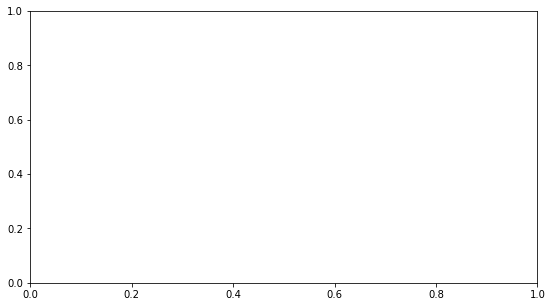

In [147]:


def plot_feats(feats,df):
    fig=pl.figure(figsize=(20,20))

    fig.subplots_adjust(hspace=0.5)
    for i, x in enumerate(feats):
        i+=1

        ax=fig.add_subplot(3,2,i)
        v=['income',x]
        df[x]=pd.cut(df[x],20)
        ndata=df.groupby(v).count().reset_index()
        
        lt50=ndata[ndata['income']=='<=50']
        gt50=ndata[ndata['income']=='>50']
        if x in ['capital-loss', 'capital-gain', 'hours-per-week']:
            ax.set_ylim(0,2000)
            ax.set_yticks([0, 500, 1000, 1500, 2000])
#         ax.hist(lt50[x],color='g', bins=20)
#         ax.hist(gt50[x],color='r', bins=20)
        
        ax.bar(lt50[x],lt50['workclass'],color='g')

#         ax.plot(gt50[x],gt50['workclass'],color='c')

        ax.set_title('Distribution of %s by Income' %(x))
        ax.legend(['<=50k',">50k"])
    display(data[feats].describe())
plot_feats(feats_num, data)
    
    

As we can see capital-gains and capital-loss need to be normalized a bit since the data is very right skewed. Let us conduct a log transformation on this data.


,age,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


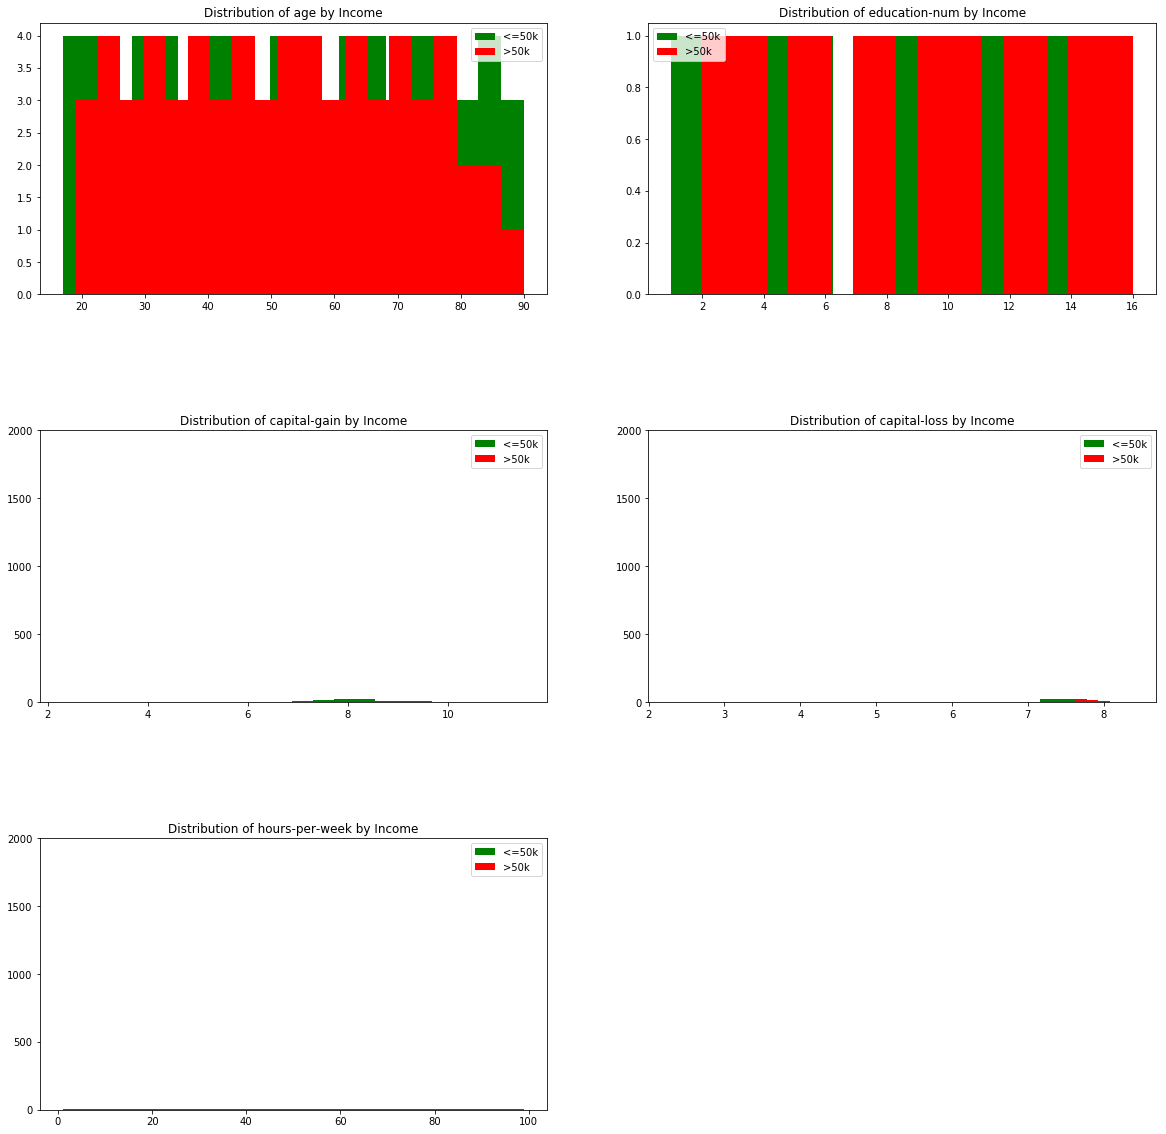

In [135]:
skewed=['capital-gain','capital-loss']
features_log_x=pd.DataFrame.copy(data)
features_log_x[skewed]=features_log_x[skewed].apply(lambda x:np.log(x+10))
plot_feats(feats_num, features_log_x)


